<img src="https://avatars.githubusercontent.com/u/74911464?s=200&v=4"
     alt="OpenEO Platform logo"
     style="float: left; margin-right: 10px;" />
# openEO Platform

## Advanced data processing
### Snow monitoring

In [1]:
import openeo
from openeo.processes import eq
import rioxarray
import xarray as xr

Before starting, please check to have the latest version of openeo installed, which is currently `0.10.0`.

In [2]:
openeo.__version__

'0.10.0'

Connect and authenticate with openEO Platform

In [3]:
# backend = 'https://openeo.cloud'
backend = 'https://openeo-dev.vito.be'
conn = openeo.connect(backend).authenticate_oidc()

Authenticated using refresh token.


This is the pre-defined AOI for this example. It is covering the [Orobie Alps](https://en.wikipedia.org/wiki/Bergamasque_Alps), including mountain peaks up to 3038 meters high.

If you want to work on a different area, you can provide different lat/lon coordinates:

In [4]:
spatial_extent  = {'west': 9.663849, 'east': 10.200806, 'south': 46.009728, 'north': 46.135486}

### Snow mask generation with Sentinel-2 SCL layer (Scene Classification)

You can find more information about the Sentinel-2 SCL layer here https://sentinel.esa.int/web/sentinel/technical-guides/sentinel-2-msi/level-2a/algorithm

If you want to know more about the Sentinel-2 L2A collection, uncomment and run the next cell.

In [5]:
# conn.describe_collection('SENTINEL2_L2A') 

In [6]:
collection      = 'SENTINEL2_L2A'
temporal_extent = ['2020-11-01', '2021-06-30']
bands           = ['SCL']

S2_SCL = conn.load_collection(collection,spatial_extent=spatial_extent,bands=bands,temporal_extent=temporal_extent)

We generate a boolean mask based on the SCL layer. Where SCL has value 11 (snow and ice), our mask will be set to 1.

In [7]:
S2_SCL_snow = (S2_SCL.band("SCL") == 11)

We can use aggregate_temporal_period to get a weekly snow mask.

More information about `aggregate_temporal_period` can be found here:

https://processes.openeo.org/#aggregate_temporal_period

https://open-eo.github.io/openeo-python-client/api.html?highlight=aggregate_temporal_period#openeo.rest.datacube.DataCube.aggregate_temporal_period

In [8]:
S2_SCL_snow_weekly = S2_SCL_snow.aggregate_temporal_period(period='week',reducer='max')

We can now download the result with a sync call.

Please note: this works only for limited areas. For larger processing use a batch job instead.

In [9]:
S2_SCL_snow_weekly.download('S2_SCL_snow_weekly_Orobie_Alps.nc')

Using xArray, we can open and visualize our result:

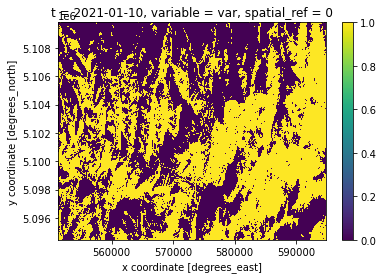

In [10]:
S2_SCL_snow_weekly_ds = xr.open_dataset('S2_SCL_snow_weekly_Orobie_Alps.nc')
S2_crs = S2_SCL_snow_weekly_ds.crs.attrs['crs_wkt']
S2_SCL_snow_weekly_ds = S2_SCL_snow_weekly_ds.drop('crs').to_array().rio.write_crs(S2_crs)[0]
S2_SCL_snow_week = S2_SCL_snow_weekly_ds.loc[dict(t=S2_SCL_snow_weekly_ds.t[11])]
S2_SCL_snow_week.plot.imshow()

### Optical RGB composite for visual reference

In [11]:
collection      = 'SENTINEL2_L2A'
temporal_extent = ['2021-01-01', '2021-01-31']
bands           = ['B02','B03','B04']

S2_BGR = conn.load_collection(collection,spatial_extent=spatial_extent,bands=bands,temporal_extent=temporal_extent)
S2_BGR = S2_BGR.reduce_dimension(dimension='t',reducer='min')
S2_BGR.download('S2_BGR_Orobie_Alps.nc')

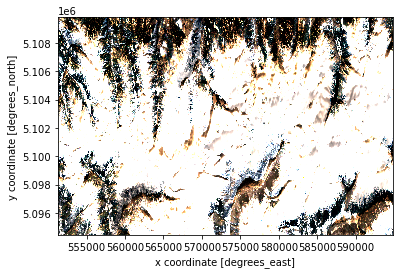

In [12]:
S2_BGR = xr.open_dataset('S2_BGR_Orobie_Alps.nc')
S2_BGR = S2_BGR.rio.write_crs(S2_BGR.crs.attrs['crs_wkt'])
S2_BGR = (S2_BGR.drop('crs').to_array() / 2000).clip(0,1)
S2_BGR.plot.imshow()

### Snow mask generation with MODIS NDSI

Sentinel-2 (A and B) have together a revisit time of 5 days.

This means that data for our area of interest is not updated daily. Therefore, if we would need to get a daily snow cover map, we should use a different data source.

MODIS is designed to provide atleast daily observations, but it has a coarser resolution (~500m) compared to Sentinel-2 (10:60m).

If you want to know more about the MODIS collection, uncomment and run the next cell.

In [14]:
#conn.describe_collection('MODIS') 

In [13]:
collection      = 'MODIS'
temporal_extent = ['2020-11-01', '2021-06-30']
bands           = ['B04','B06']

MODIS_green_swir  = conn.load_collection(collection,spatial_extent=spatial_extent,bands=bands,temporal_extent=temporal_extent)

We can compute the NDSI (Normalized Difference Snow Index) using the green (B04) and swir (B06) bands of MODIS.

Additional information about MODIS and the NDSI usage for snow detection can be found here: https://modis-snow-ice.gsfc.nasa.gov/uploads/C6_MODIS_Snow_User_Guide.pdf

In [14]:
MODIS_NDSI = ( MODIS_green_swir.band('B04') - MODIS_green_swir.band('B06')) / (MODIS_green_swir.band('B04') + MODIS_green_swir.band('B06'))

MODIS acquires data every day, but we would like to compare the result with Sentinel-2. We can again aggregate with a weekly period to align and compare the results.

We compute the maximum value of the NDSI over a week:

In [15]:
MODIS_NDSI_weekly = MODIS_NDSI.aggregate_temporal_period(period='week',reducer='max')

and we consider as covered by snow all the pixels with an NDSI value greater than 0.4:

In [16]:
MODIS_snow_weekly = MODIS_NDSI_weekly.apply(lambda x: x > 0.4)

In [17]:
MODIS_snow_weekly.download('MODIS_snow_Orobie_Alps.nc')

Now our snow mask is ready. However, if we want to compare it with the Sentinel-2 one, we would need to apply one last step.

MODIS has a different resolution and projection compared to Sentinel-2 and therefore we need to resample MODIS to align with Sentinel-2:

In [18]:
MODIS_snow_weekly = xr.open_dataset('MODIS_snow_Orobie_Alps.nc')
MODIS_crs = MODIS_snow_weekly.crs.attrs['crs_wkt']
MODIS_snow_weekly = MODIS_snow_weekly.drop('crs').to_array().rio.write_crs(4326)[0]

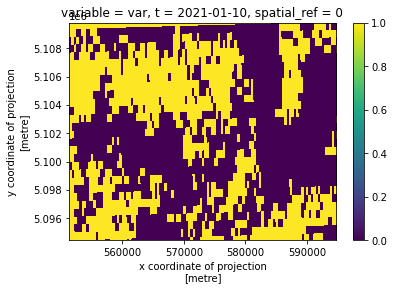

In [19]:
MODIS_snow_weekly_UTM = MODIS_snow_weekly[10].rio.reproject_match(S2_SCL_snow_week)
MODIS_snow_weekly_UTM.clip(0,1).plot.imshow()

Note: the snow mask obtained with MODIS does not consider clouds whereas the SCL layer of Sentinel-2 has been processed by a dedicated algorithm.

The alignment of MODIS and Sentinel-2 can be performed also in openEO using `resample_cube_spatial`.

https://processes.openeo.org/#resample_cube_spatial

`MODIS_snow_weekly_UTM = MODIS_snow_weekly.resample_cube_spatial(S2_SCL_snow_weekly)`

### Wetsnow detection using Sentinel-1

Please refer to https://github.com/Open-EO/openeo-usecases/tree/master/eurac_wetsnow_usecase for more information about the original use case.

The Sentinel-1 collection we will use is not global, please have a look here to check if the area you are interested in is covered:

https://editor.openeo.cloud/?preview-collection=S1_GRD_SIGMA0_ASCENDING

https://editor.openeo.cloud/?preview-collection=S1_GRD_SIGMA0_DESCENDING

In [25]:
collection      = 'S1_GRD_SIGMA0_DESCENDING'
bands           = ["VV","VH"]
temporal_extent = ['2020-11-01', '2021-06-30']

In [26]:
s1_vvvh = conn.load_collection(
    collection,
    spatial_extent=spatial_extent, 
    bands=["VV", "VH"],
    temporal_extent=temporal_extent,
).apply(lambda x: 10 * x.log(base=10))

s1_angle = conn.load_collection(
    collection,
    spatial_extent=spatial_extent, 
    bands=["angle"],
    temporal_extent=["2020-11-01", "2020-11-10"],
)

In the first step every timestep of the Sentinel-1 backscatter data is normalized with the mean of the time series for the two polarizations VV and VH.

In [27]:
rat_vvvh = s1_vvvh.merge_cubes(s1_vvvh.mean_time(), overlap_resolver="subtract")

In the second step the Sentinel-1 local incident angle is classified into a weight layer.

In [28]:
s1_lia_angle = s1_angle.min_time().band("angle") / 1000

theta_1 = 20
theta_2 = 45
k = 0.5

weight = (
    (0.5 * ((theta_2 - s1_lia_angle) * 0.04 + 1))
    .mask(s1_lia_angle < theta_1, replacement=1)
    .mask(s1_lia_angle < theta_2, replacement=k)
)

The time series of the normalized backscatter images and the weight layer are combined in a thrid step to retrieve a wet snow map solely based on Sentinel-1 data.

In [29]:
rc_cube = rat_vvvh.merge_cubes(weight)

from openeo.metadata import Band
rc_cube.metadata = rc_cube.metadata.append_band(Band("angle"))

rc_w = rc_cube.band("angle")
rc = rc_w * rc_cube.band("VH") + (1-rc_w) * rc_cube.band("VV")

rc_weekly = rc.aggregate_temporal_period(period='week',reducer='mean')

wetsnow = rc_weekly.mask(rc_weekly <= -2,replacement = 10).mask(rc_weekly > -2,replacement = 20)

Now the Sentinel-1 based weekly wetsnow map is ready. The final step will consist in using the Sentinel-2 based snow mask to create a final product:

In [30]:
# wetsnow_masked = wetsnow.filter_temporal(temporal_extent).merge_cubes(S2_SCL_snow_weekly.filter_temporal(temporal_extent),overlap_resolver='multiply')
wetsnow_masked = wetsnow.merge_cubes(S2_SCL_snow_weekly,overlap_resolver='multiply')

In [31]:
wetsnow_masked.download('wetsnow_masked.nc')

OpenEoApiError: [400] unknown: Merging cubes with an overlap resolver is only supported when band counts are the same. I got: 0 and 1

In [31]:
wetsnow.download('wetsnow_weekly.nc')

Output of `wetsnow_weekly`:

In [32]:
xr.open_dataset('wetsnow_weekly.nc')

<xarray.Dataset>
Dimensions:  (t: 35, x: 4352, y: 1536)
Coordinates:
  * t        (t) datetime64[ns] 2020-11-01 2020-11-08 ... 2021-06-20 2021-06-27
  * x        (x) float64 5.513e+05 5.513e+05 5.513e+05 ... 5.948e+05 5.948e+05
  * y        (y) float64 5.11e+06 5.11e+06 5.11e+06 ... 5.094e+06 5.094e+06
Data variables:
    crs      |S1 ...
    var      (t, y, x) float32 ...
Attributes:
    Conventions:  CF-1.8
    institution:  openEO platform

Output of `wetsnow_masked`:

Output of `S2_SCL_snow_weekly`:

In [ ]:
xr.open_dataset('S2_SCL_snow_weekly_Orobie_Alps.nc')